## Deep Learning Term Project for ECG (DIL700)

# Iteration 5

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
from keras import Sequential
from keras.layers import Convolution1D, MaxPool1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')

import datetime

# Custom functions
from general_functions import *

# Loading dataset

    Number of Samples: 14552
    Number of Categories: 2
    Sampling Frequency: 125Hz
    Data Source: Physionet's PTB Diagnostic Database

This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs. (https://www.kaggle.com/datasets/shayanfazeli/heartbeat)

In [2]:
normal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_normal.csv',header=None)
abnormal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_abnormal.csv',header=None)
# Combine to a full dataset
full_df = pd.concat([normal_df, abnormal_df], axis=0, ignore_index=True)

In [3]:
print('Number of samples per class: \n')
print('Normal:                 ', len(full_df[full_df[187]==0]))
print('Abnormal:               ', len(full_df[full_df[187]==1]))

Number of samples per class: 

Normal:                  4046
Abnormal:                10506


In [4]:
normal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,1.000000,0.929586,0.503550,0.293491,0.169822,0.159763,0.130769,0.125444,0.137278,0.111243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4042,1.000000,0.637579,0.154837,0.061983,0.088965,0.083374,0.065143,0.057365,0.060039,0.060039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4043,1.000000,0.872574,0.465071,0.232212,0.126132,0.155886,0.174644,0.190168,0.203752,0.168823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4044,0.915983,0.529373,0.288406,0.144536,0.171802,0.180669,0.177566,0.176458,0.178896,0.180448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Normal only contains class 0 --> healthy
normal_df[187].unique()

array([0.])

In [6]:
abnormal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10502,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10503,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10504,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
# Abnormal only contains class 1 --> not healthy
abnormal_df[187].unique()

array([1.])

In [8]:
full_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14547,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14548,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14549,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14550,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
# Full contains both classes
full_df[187].unique()

array([0., 1.])

In [10]:
labels = ['Normal', 'Abnormal']

# Preparation

In [11]:
from sklearn.model_selection import train_test_split

# split the data into features and target
X = full_df.drop(187, axis=1)
y = full_df[187]

# Split data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [12]:
# validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=42)

In [13]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.052197,0.055676,0.055676,0.057851,0.060896,0.067856,0.066551,0.0,0.0,0.0
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [14]:
train_df = X_train.copy()
train_df[187] = y_train
valid_df = X_valid.copy()
valid_df[187] = y_valid
test_df = X_test.copy()	
test_df[187] = y_test

train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.055676,0.055676,0.057851,0.060896,0.067856,0.066551,0.0,0.0,0.0,0.0
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0


In [15]:
print('Number of samples in training data:')
print('Normal:                              ', len(train_df[train_df[187]==0]))
print('Abnormal:                            ', len(train_df[train_df[187]==1]))

Number of samples in training data:
Normal:                               2589
Abnormal:                             6723


In [16]:
print('Number of samples in validation data:')
print('Normal:                              ', len(valid_df[valid_df[187]==0]))
print('Abnormal:                            ', len(valid_df[valid_df[187]==1]))

Number of samples in validation data:
Normal:                               648
Abnormal:                             1681


In [17]:
print('Number of samples in test data:')
print('Normal:                              ', len(test_df[test_df[187]==0]))
print('Abnormal:                            ', len(test_df[test_df[187]==1]))

Number of samples in test data:
Normal:                               809
Abnormal:                             2102


Same ratio of the two classes in both the datasets

# ANN

# Dropout with Rate 0.08

In [18]:
name = 'ann_dropout_008'

In [19]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.Dropout(rate=0.08))
    # AlphaDropout
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 2s 4ms/step - loss: 0.4543 - accuracy: 0.7776 - val_loss: 0.3757 - val_accuracy: 0.8248
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3783 - accuracy: 0.8197 - val_loss: 0.3145 - val_accuracy: 0.8562
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3441 - accuracy: 0.8378 - val_loss: 0.2831 - val_accuracy: 0.8720
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3039 - accuracy: 0.8624 - val_loss: 0.3075 - val_accuracy: 0.8678
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2894 - accuracy: 0.8721 - val_loss: 0.2574 - val_accuracy: 0.8866
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2601 - accuracy: 0.8873 - val_loss: 0.2276 - val_accuracy: 0.9141
Epoch 7/100
291/291 [==============================] - 1s 2ms/step - loss: 0.2639 - accuracy: 0.8894 - val_loss: 0.2495 - val_accuracy: 0.8918

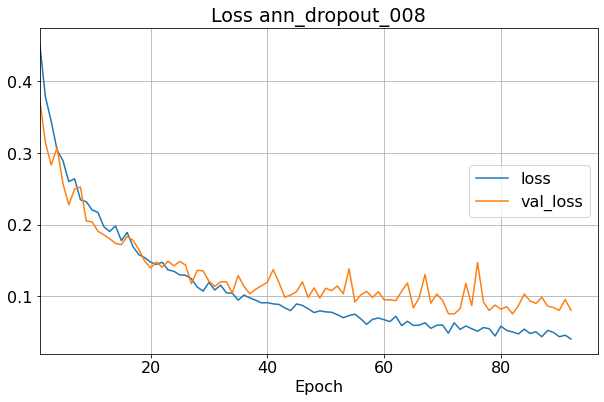

In [21]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

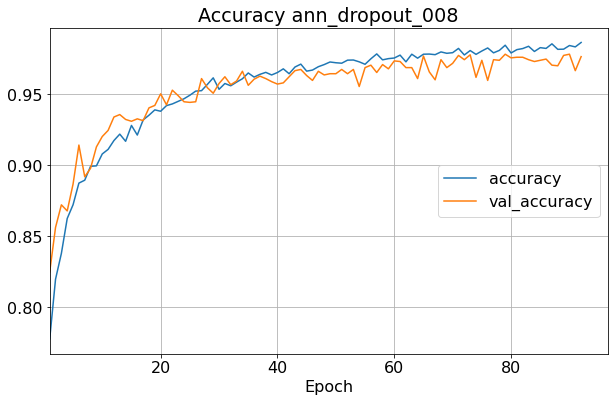

In [22]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [23]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.96908


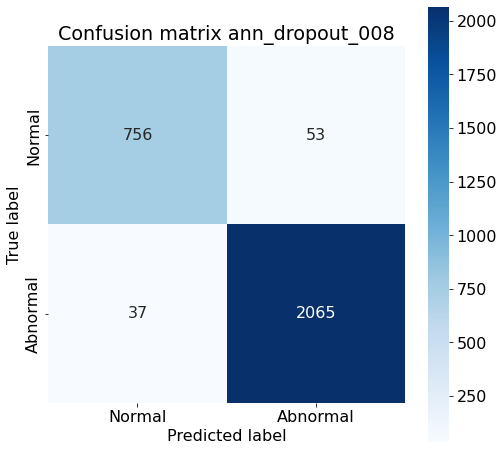

In [24]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [25]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.93448702 0.98239772]
Macro/average accuracy:  0.9584423687370554


In [26]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9533    0.9345    0.9438       809
    Abnormal     0.9750    0.9824    0.9787      2102

    accuracy                         0.9691      2911
   macro avg     0.9642    0.9584    0.9612      2911
weighted avg     0.9690    0.9691    0.9690      2911



### False Positive Rate

In [27]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  37
Percentage of sick persons that are classified as normal:  1.7602283539486203 %


# Dropout with Rate 0.10

In [28]:
name = 'ann_dropout_010'

In [29]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.Dropout(rate=0.10))
    # AlphaDropout
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 2s 5ms/step - loss: 0.4694 - accuracy: 0.7606 - val_loss: 0.3535 - val_accuracy: 0.8261
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3797 - accuracy: 0.8136 - val_loss: 0.3795 - val_accuracy: 0.8270
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3544 - accuracy: 0.8329 - val_loss: 0.3454 - val_accuracy: 0.8557
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3235 - accuracy: 0.8498 - val_loss: 0.2863 - val_accuracy: 0.8720
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3062 - accuracy: 0.8643 - val_loss: 0.2858 - val_accuracy: 0.8746
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2887 - accuracy: 0.8666 - val_loss: 0.2460 - val_accuracy: 0.9004
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2734 - accuracy: 0.8814 - val_loss: 0.2375 - val_accuracy: 0.8987

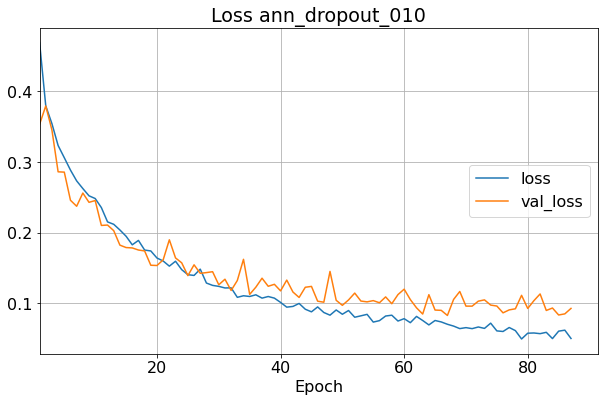

In [31]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

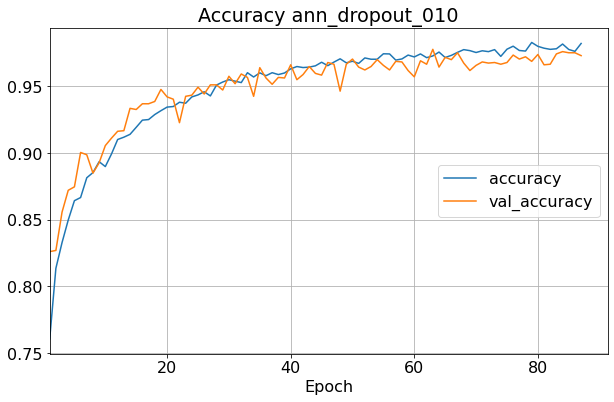

In [32]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [33]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.97046


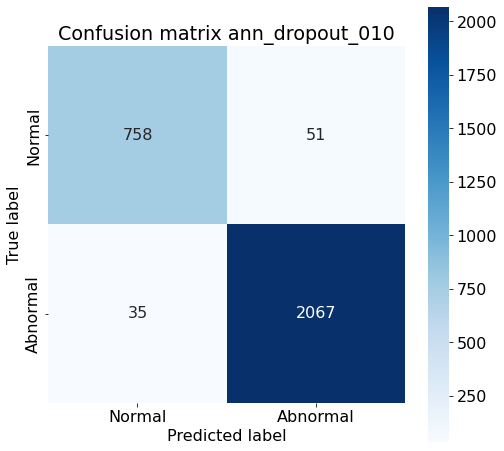

In [34]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [35]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.93695921 0.98334919]
Macro/average accuracy:  0.9601542000731542


In [36]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9559    0.9370    0.9463       809
    Abnormal     0.9759    0.9833    0.9796      2102

    accuracy                         0.9705      2911
   macro avg     0.9659    0.9602    0.9630      2911
weighted avg     0.9703    0.9705    0.9704      2911



### False Positive Rate

In [37]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  35
Percentage of sick persons that are classified as normal:  1.6650808753568032 %


# Dropout with Rate 0.12

In [38]:
name = 'ann_dropout_012'

In [39]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.Dropout(rate=0.12))
    # AlphaDropout
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')


Epoch 1/100
291/291 [==============================] - 2s 3ms/step - loss: 0.4685 - accuracy: 0.7651 - val_loss: 0.4049 - val_accuracy: 0.7991
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3999 - accuracy: 0.8053 - val_loss: 0.3616 - val_accuracy: 0.8231
Epoch 3/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3703 - accuracy: 0.8242 - val_loss: 0.3071 - val_accuracy: 0.8583
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3306 - accuracy: 0.8488 - val_loss: 0.2856 - val_accuracy: 0.8815
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3117 - accuracy: 0.8574 - val_loss: 0.2678 - val_accuracy: 0.8888
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3067 - accuracy: 0.8610 - val_loss: 0.2617 - val_accuracy: 0.8909
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2775 - accuracy: 0.8770 - val_loss: 0.2422 - val_accuracy: 0.8987

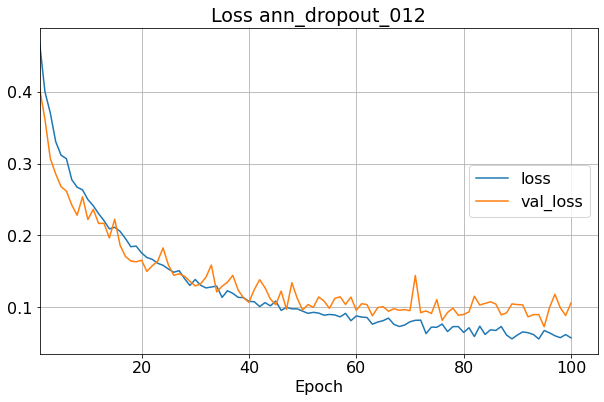

In [41]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

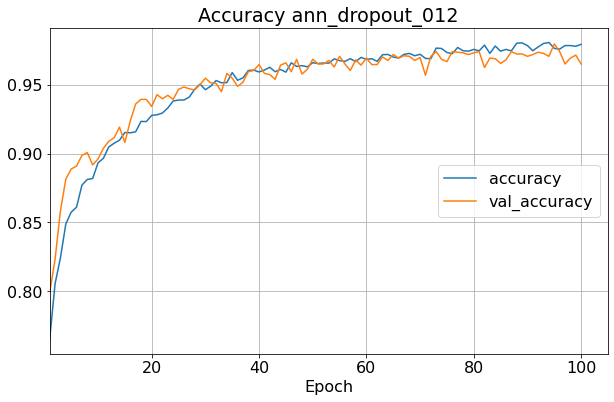

In [42]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [43]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.96943


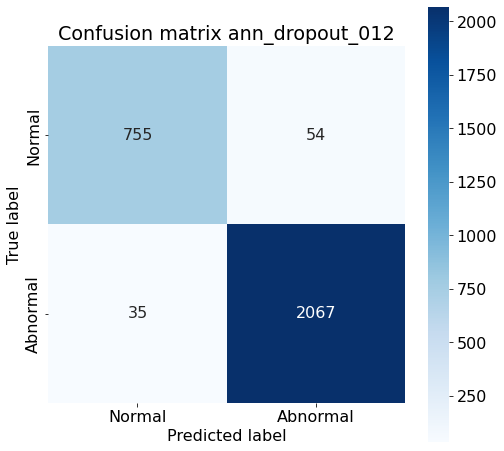

In [44]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [45]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.93325093 0.98334919]
Macro/average accuracy:  0.9583000591584446


In [46]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9557    0.9333    0.9443       809
    Abnormal     0.9745    0.9833    0.9789      2102

    accuracy                         0.9694      2911
   macro avg     0.9651    0.9583    0.9616      2911
weighted avg     0.9693    0.9694    0.9693      2911



### False Positive Rate

In [47]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  35
Percentage of sick persons that are classified as normal:  1.6650808753568032 %


# Dropout with Rate 0.14

In [48]:
name = 'ann_dropout_014'

In [49]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.Dropout(rate=0.14))
    # AlphaDropout
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')


Epoch 1/100
291/291 [==============================] - 2s 3ms/step - loss: 0.4898 - accuracy: 0.7605 - val_loss: 0.3774 - val_accuracy: 0.8287
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4111 - accuracy: 0.7988 - val_loss: 0.3751 - val_accuracy: 0.8291
Epoch 3/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3847 - accuracy: 0.8218 - val_loss: 0.3090 - val_accuracy: 0.8566
Epoch 4/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3570 - accuracy: 0.8293 - val_loss: 0.3106 - val_accuracy: 0.8527
Epoch 5/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3360 - accuracy: 0.8425 - val_loss: 0.2839 - val_accuracy: 0.8660
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3135 - accuracy: 0.8522 - val_loss: 0.2581 - val_accuracy: 0.8939
Epoch 7/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3020 - accuracy: 0.8610 - val_loss: 0.2530 - val_accuracy: 0.8939

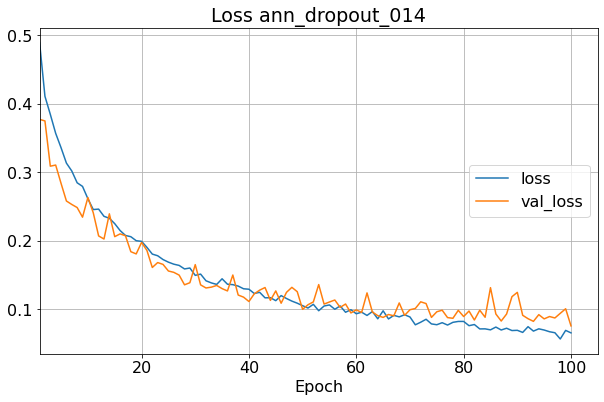

In [51]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

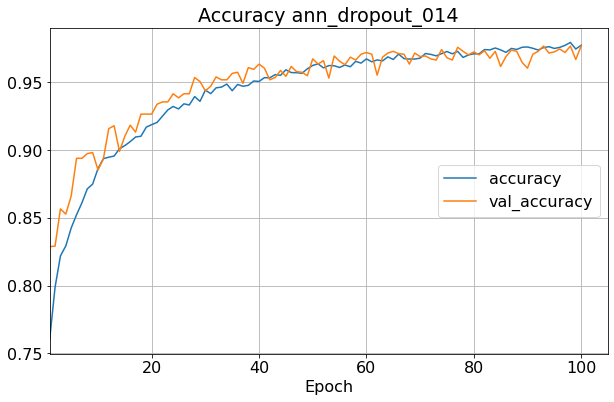

In [52]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [53]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.97561


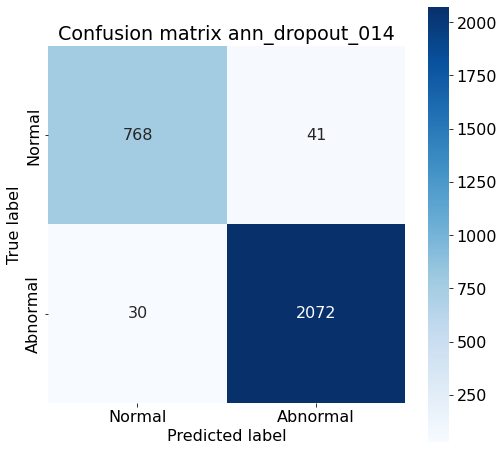

In [54]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [55]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.94932015 0.98572788]
Macro/average accuracy:  0.9675240132712504


In [56]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9624    0.9493    0.9558       809
    Abnormal     0.9806    0.9857    0.9832      2102

    accuracy                         0.9756      2911
   macro avg     0.9715    0.9675    0.9695      2911
weighted avg     0.9755    0.9756    0.9756      2911



### False Positive Rate

In [57]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  30
Percentage of sick persons that are classified as normal:  1.4272121788772598 %


# AlphaDropout with Rate 0.10

Alpha dropout remains bad, even if the rate is optimized.

In [58]:
name = 'ann_alphadropout_010'

In [59]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.AlphaDropout(rate=0.10))
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')


Epoch 1/100
291/291 [==============================] - 2s 3ms/step - loss: 0.5605 - accuracy: 0.7161 - val_loss: 0.4337 - val_accuracy: 0.7669
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4488 - accuracy: 0.7616 - val_loss: 0.4256 - val_accuracy: 0.7729
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 0.4224 - accuracy: 0.7744 - val_loss: 0.3939 - val_accuracy: 0.8016
Epoch 4/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4121 - accuracy: 0.7852 - val_loss: 0.3899 - val_accuracy: 0.8111
Epoch 5/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3936 - accuracy: 0.8006 - val_loss: 0.3674 - val_accuracy: 0.8231
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3849 - accuracy: 0.8101 - val_loss: 0.3481 - val_accuracy: 0.8394
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3636 - accuracy: 0.8259 - val_loss: 0.3153 - val_accuracy: 0.8613

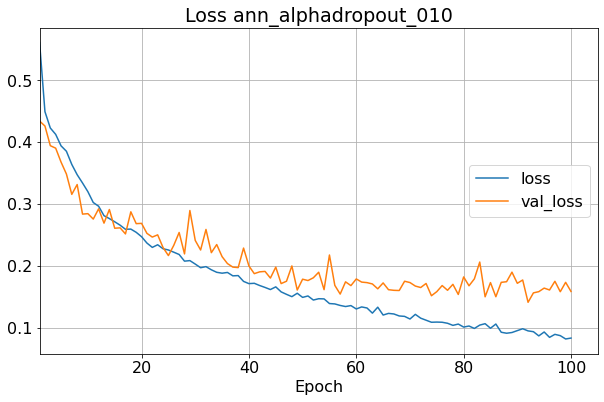

In [61]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

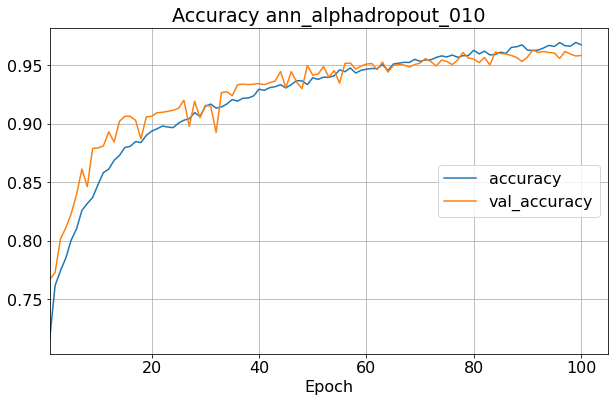

In [62]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [63]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.95362


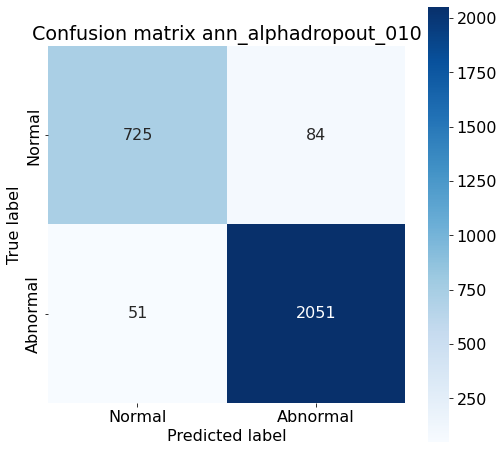

In [64]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [65]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.89616811 0.97573739]
Macro/average accuracy:  0.9359527508676768


In [66]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9343    0.8962    0.9148       809
    Abnormal     0.9607    0.9757    0.9681      2102

    accuracy                         0.9536      2911
   macro avg     0.9475    0.9360    0.9415      2911
weighted avg     0.9533    0.9536    0.9533      2911



### False Positive Rate

In [67]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  51
Percentage of sick persons that are classified as normal:  2.4262607040913418 %


# Batch Normalization

In [68]:
name = 'ann_batch_norm'

In [69]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]

# model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1])))
# model.add(tf.keras.layers.BatchNormalization())

# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], input_dim=X_train.shape[1]))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(activation_function))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i]))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(activation_function))
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 3s 4ms/step - loss: 0.4331 - accuracy: 0.8051 - val_loss: 0.3553 - val_accuracy: 0.8416
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3199 - accuracy: 0.8606 - val_loss: 0.2917 - val_accuracy: 0.8892
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2685 - accuracy: 0.8827 - val_loss: 0.2374 - val_accuracy: 0.9094
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2461 - accuracy: 0.8943 - val_loss: 0.2221 - val_accuracy: 0.9051
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2244 - accuracy: 0.9043 - val_loss: 0.2378 - val_accuracy: 0.8978
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2198 - accuracy: 0.9080 - val_loss: 0.1877 - val_accuracy: 0.9188
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2004 - accuracy: 0.9169 - val_loss: 0.2815 - val_accuracy: 0.8789

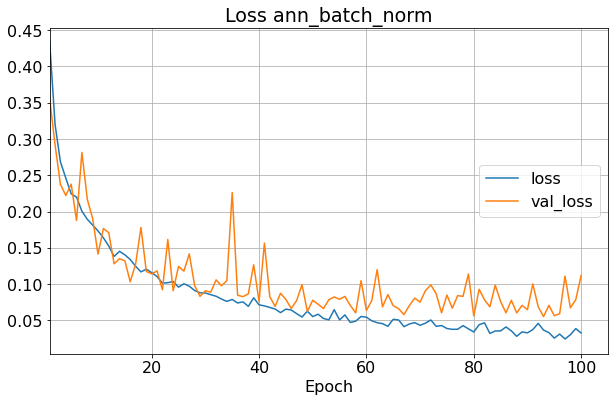

In [71]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

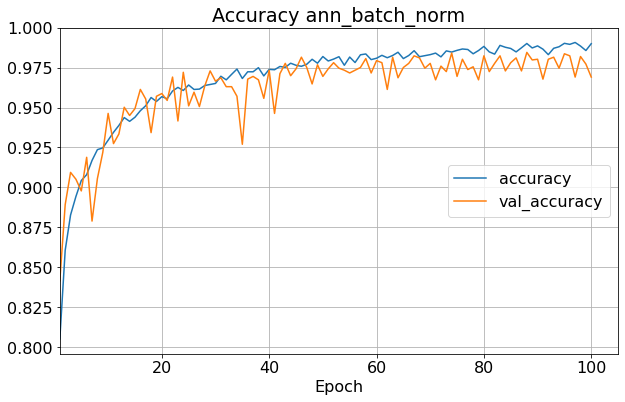

In [72]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [73]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.97939


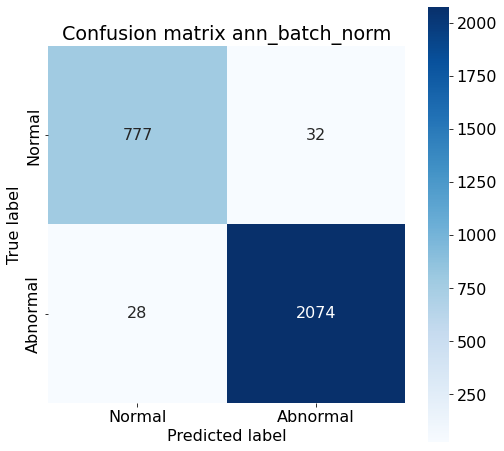

In [74]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [75]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.96044499 0.98667935]
Macro/average accuracy:  0.973562173408338


In [76]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9652    0.9604    0.9628       809
    Abnormal     0.9848    0.9867    0.9857      2102

    accuracy                         0.9794      2911
   macro avg     0.9750    0.9736    0.9743      2911
weighted avg     0.9794    0.9794    0.9794      2911



### False Positive Rate

In [77]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  28
Percentage of sick persons that are classified as normal:  1.3320647002854424 %


# Batch Normalization - BN before first dense layer

In [78]:
name = 'ann_batch_norm_input'

In [79]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]

# model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1])))
model.add(tf.keras.layers.BatchNormalization())

# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], input_dim=X_train.shape[1]))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(activation_function))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i]))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(activation_function))
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [80]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 3s 5ms/step - loss: 0.4401 - accuracy: 0.7976 - val_loss: 0.3818 - val_accuracy: 0.8240
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3173 - accuracy: 0.8595 - val_loss: 0.2709 - val_accuracy: 0.8888
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2810 - accuracy: 0.8789 - val_loss: 0.2519 - val_accuracy: 0.9025
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2470 - accuracy: 0.8962 - val_loss: 0.2210 - val_accuracy: 0.9077
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2291 - accuracy: 0.9042 - val_loss: 0.2087 - val_accuracy: 0.9197
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2086 - accuracy: 0.9118 - val_loss: 0.1857 - val_accuracy: 0.9249
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.1945 - accuracy: 0.9194 - val_loss: 0.1576 - val_accuracy: 0.9416

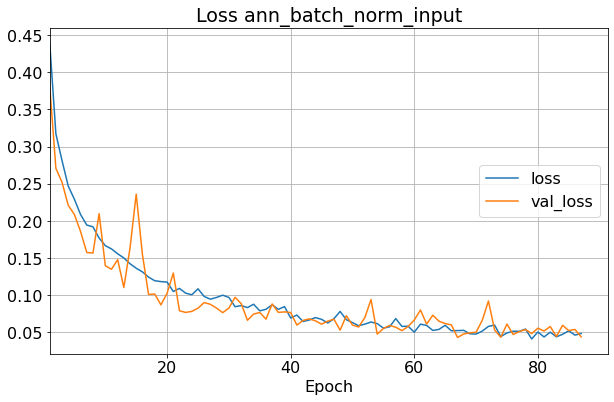

In [81]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

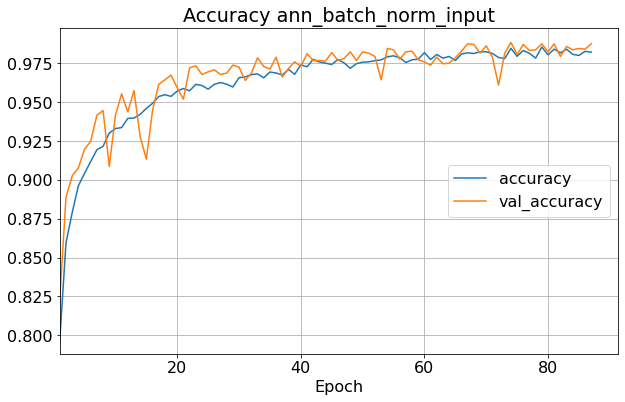

In [82]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [83]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.98420


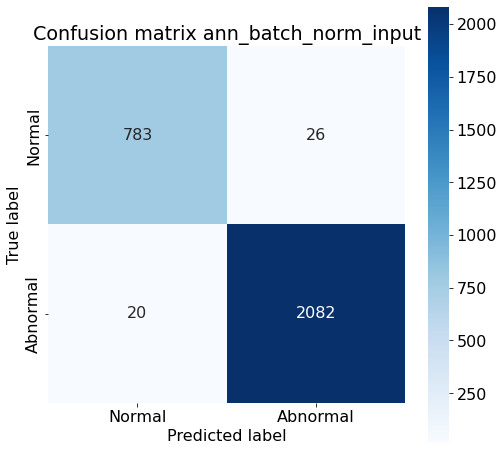

In [84]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [85]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.96786156 0.99048525]
Macro/average accuracy:  0.9791734048095933


In [86]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9751    0.9679    0.9715       809
    Abnormal     0.9877    0.9905    0.9891      2102

    accuracy                         0.9842      2911
   macro avg     0.9814    0.9792    0.9803      2911
weighted avg     0.9842    0.9842    0.9842      2911



### False Positive Rate

In [87]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  20
Percentage of sick persons that are classified as normal:  0.9514747859181731 %


# CNN

# Batch Normalization - moved activation function

In [88]:
name = 'cnn_batch_norm_move_af'

In [89]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), input_shape=(X_train.shape[1],1)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
    else:
        model.add(Convolution1D(64, (masked_kernels[i])))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 24s 74ms/step - loss: 0.2880 - accuracy: 0.8821 - val_loss: 0.4795 - val_accuracy: 0.7471
Epoch 2/100
291/291 [==============================] - 21s 73ms/step - loss: 0.1243 - accuracy: 0.9537 - val_loss: 0.5865 - val_accuracy: 0.8038
Epoch 3/100
291/291 [==============================] - 22s 75ms/step - loss: 0.0784 - accuracy: 0.9714 - val_loss: 0.3136 - val_accuracy: 0.9034
Epoch 4/100
291/291 [==============================] - 22s 74ms/step - loss: 0.0623 - accuracy: 0.9769 - val_loss: 0.5229 - val_accuracy: 0.8583
Epoch 5/100
291/291 [==============================] - 22s 76ms/step - loss: 0.0521 - accuracy: 0.9810 - val_loss: 0.8235 - val_accuracy: 0.7754
Epoch 6/100
291/291 [==============================] - 25s 86ms/step - loss: 0.0322 - accuracy: 0.9901 - val_loss: 0.1146 - val_accuracy: 0.9618
Epoch 7/100
291/291 [==============================] - 26s 88ms/step - loss: 0.0169 - accuracy: 0.9942 - val_loss: 0.0621 - val_ac

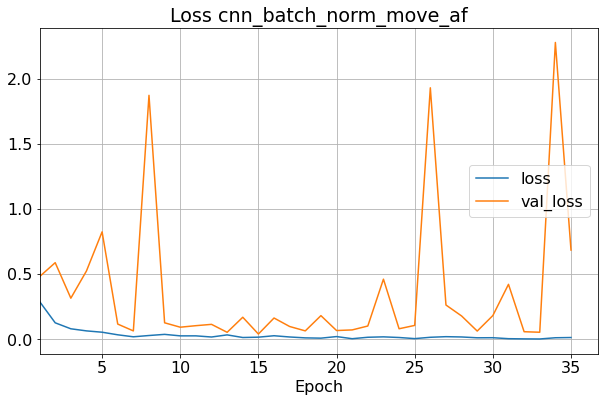

In [91]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

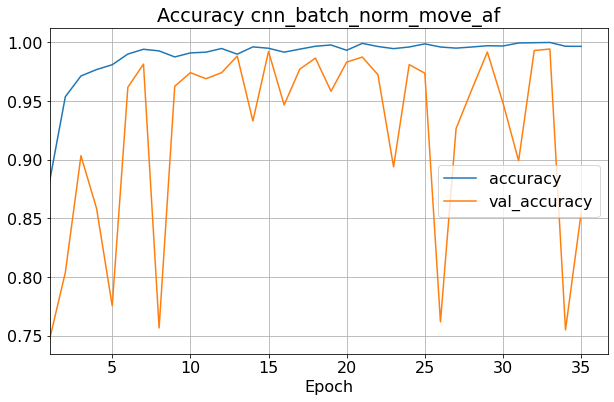

In [92]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [93]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.98969


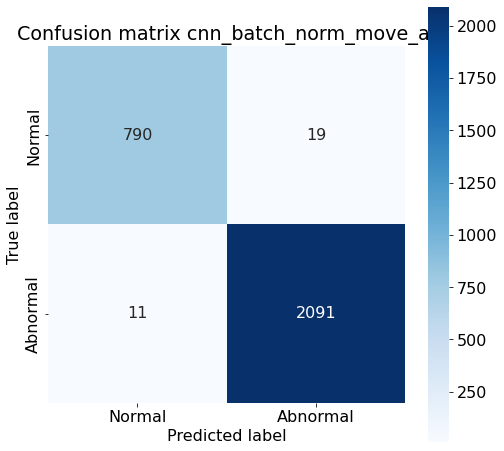

In [94]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [95]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.97651422 0.99476689]
Macro/average accuracy:  0.985640551878898


In [96]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9863    0.9765    0.9814       809
    Abnormal     0.9910    0.9948    0.9929      2102

    accuracy                         0.9897      2911
   macro avg     0.9886    0.9856    0.9871      2911
weighted avg     0.9897    0.9897    0.9897      2911



### False Positive Rate

In [97]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  11
Percentage of sick persons that are classified as normal:  0.5233111322549953 %


# Batch Normalization - added for dense layers

In [98]:
name = 'cnn_batch_norm_dense'

In [99]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), input_shape=(X_train.shape[1],1)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
    else:
        model.add(Convolution1D(64, (masked_kernels[i])))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [100]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 20s 62ms/step - loss: 0.2305 - accuracy: 0.9069 - val_loss: 1.3257 - val_accuracy: 0.7192
Epoch 2/100
291/291 [==============================] - 18s 63ms/step - loss: 0.1104 - accuracy: 0.9575 - val_loss: 0.1268 - val_accuracy: 0.9498
Epoch 3/100
291/291 [==============================] - 19s 64ms/step - loss: 0.0663 - accuracy: 0.9778 - val_loss: 0.5797 - val_accuracy: 0.8038
Epoch 4/100
291/291 [==============================] - 18s 62ms/step - loss: 0.0536 - accuracy: 0.9829 - val_loss: 0.1818 - val_accuracy: 0.9313
Epoch 5/100
291/291 [==============================] - 19s 64ms/step - loss: 0.0422 - accuracy: 0.9857 - val_loss: 0.6148 - val_accuracy: 0.8403
Epoch 6/100
291/291 [==============================] - 18s 61ms/step - loss: 0.0320 - accuracy: 0.9883 - val_loss: 0.1316 - val_accuracy: 0.9553
Epoch 7/100
291/291 [==============================] - 18s 63ms/step - loss: 0.0310 - accuracy: 0.9889 - val_loss: 1.1008 - val_ac

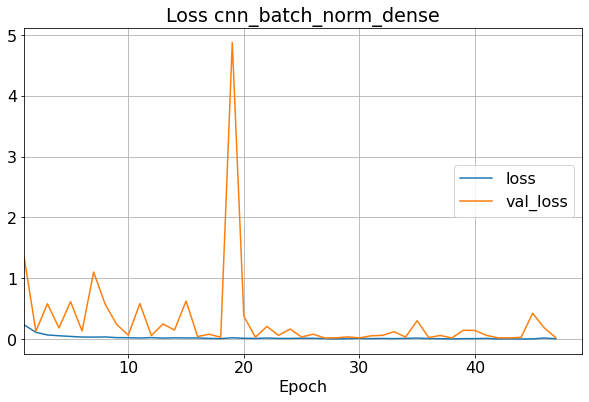

In [101]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

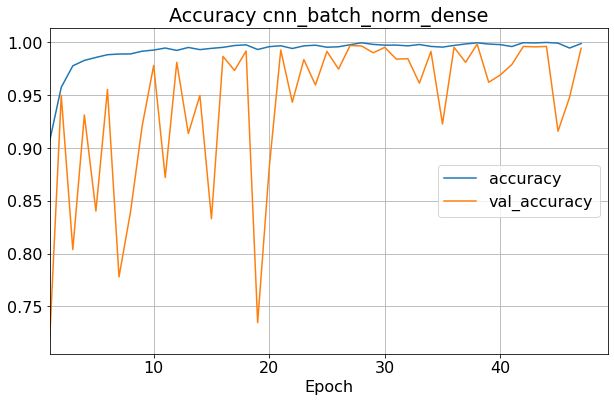

In [102]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [103]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.99244


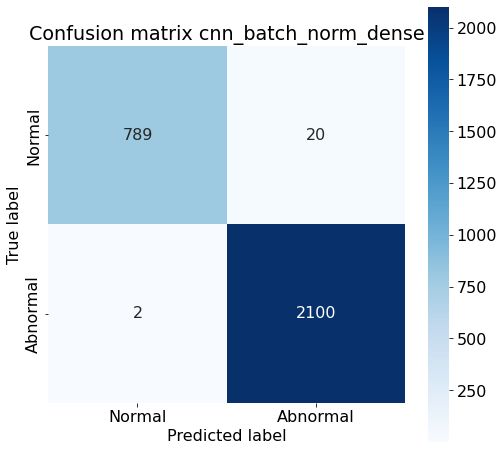

In [104]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [105]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.97527812 0.99904853]
Macro/average accuracy:  0.9871633231756441


In [106]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9975    0.9753    0.9862       809
    Abnormal     0.9906    0.9990    0.9948      2102

    accuracy                         0.9924      2911
   macro avg     0.9940    0.9872    0.9905      2911
weighted avg     0.9925    0.9924    0.9924      2911



### False Positive Rate

In [107]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  2
Percentage of sick persons that are classified as normal:  0.09514747859181732 %


# Batch Normalization - added for dense layers, original order of activation function

In [108]:
name = 'cnn_batch_norm_dense_actback'

In [109]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
        model.add(tf.keras.layers.BatchNormalization())
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [110]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 21s 63ms/step - loss: 0.2235 - accuracy: 0.9081 - val_loss: 1.2029 - val_accuracy: 0.7218
Epoch 2/100
291/291 [==============================] - 18s 62ms/step - loss: 0.1029 - accuracy: 0.9627 - val_loss: 0.4355 - val_accuracy: 0.8029
Epoch 3/100
291/291 [==============================] - 18s 61ms/step - loss: 0.0698 - accuracy: 0.9761 - val_loss: 1.0884 - val_accuracy: 0.7497
Epoch 4/100
291/291 [==============================] - 18s 61ms/step - loss: 0.0529 - accuracy: 0.9830 - val_loss: 0.0517 - val_accuracy: 0.9837
Epoch 5/100
291/291 [==============================] - 18s 61ms/step - loss: 0.0386 - accuracy: 0.9878 - val_loss: 0.2770 - val_accuracy: 0.9257
Epoch 6/100
291/291 [==============================] - 18s 61ms/step - loss: 0.0314 - accuracy: 0.9886 - val_loss: 0.2468 - val_accuracy: 0.9120
Epoch 7/100
291/291 [==============================] - 19s 64ms/step - loss: 0.0269 - accuracy: 0.9909 - val_loss: 1.9257 - val_ac

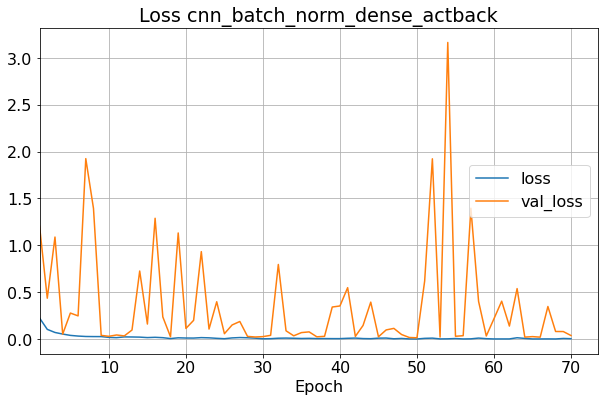

In [111]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

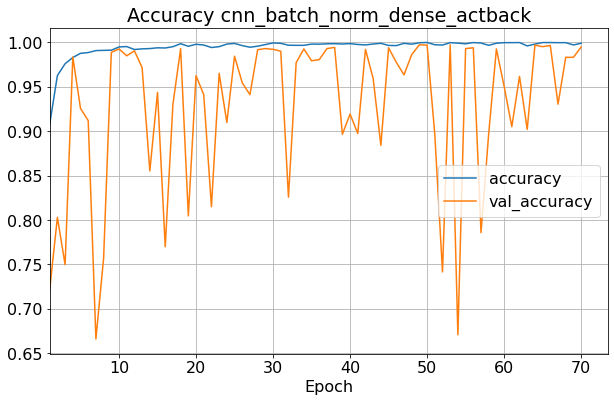

In [112]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [113]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.99656


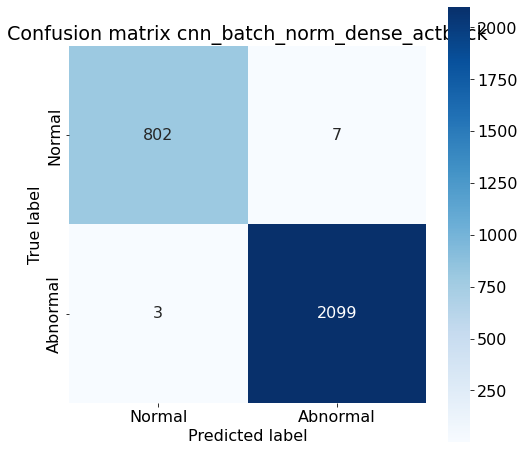

In [114]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [115]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.99134734 0.99857279]
Macro/average accuracy:  0.9949600651095725


In [116]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9963    0.9913    0.9938       809
    Abnormal     0.9967    0.9986    0.9976      2102

    accuracy                         0.9966      2911
   macro avg     0.9965    0.9950    0.9957      2911
weighted avg     0.9966    0.9966    0.9966      2911



### False Positive Rate

In [117]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  3
Percentage of sick persons that are classified as normal:  0.142721217887726 %


# Dropout with Rate 0.10

In [118]:
name = 'cnn_dropout_010'

In [119]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
        model.add(tf.keras.layers.BatchNormalization())
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons))
    model.add(tf.keras.layers.Activation('relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [120]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 23s 73ms/step - loss: 0.2658 - accuracy: 0.8918 - val_loss: 0.9121 - val_accuracy: 0.7218
Epoch 2/100
291/291 [==============================] - 22s 75ms/step - loss: 0.1215 - accuracy: 0.9523 - val_loss: 1.9437 - val_accuracy: 0.7377
Epoch 3/100
291/291 [==============================] - 25s 85ms/step - loss: 0.0827 - accuracy: 0.9724 - val_loss: 0.1455 - val_accuracy: 0.9506
Epoch 4/100
291/291 [==============================] - 26s 88ms/step - loss: 0.0670 - accuracy: 0.9767 - val_loss: 0.0811 - val_accuracy: 0.9729
Epoch 5/100
291/291 [==============================] - 24s 84ms/step - loss: 0.0412 - accuracy: 0.9871 - val_loss: 0.1200 - val_accuracy: 0.9575
Epoch 6/100
291/291 [==============================] - 24s 83ms/step - loss: 0.0400 - accuracy: 0.9867 - val_loss: 0.1436 - val_accuracy: 0.9545
Epoch 7/100
291/291 [==============================] - 23s 81ms/step - loss: 0.0279 - accuracy: 0.9902 - val_loss: 0.2429 - val_ac

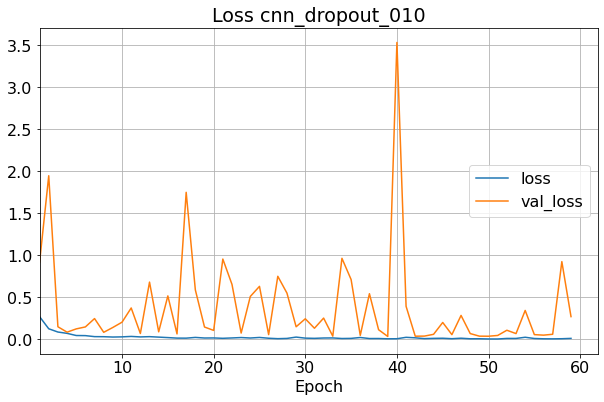

In [121]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

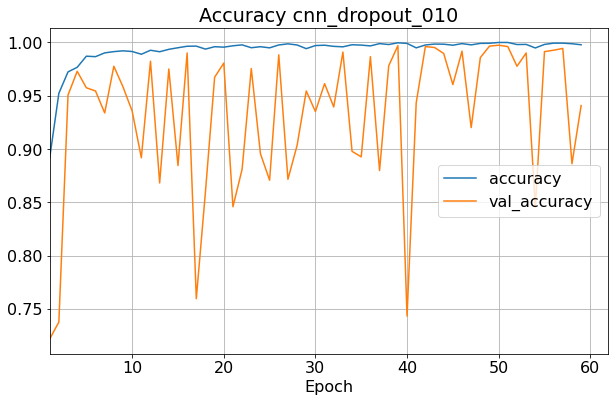

In [122]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [123]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.99553


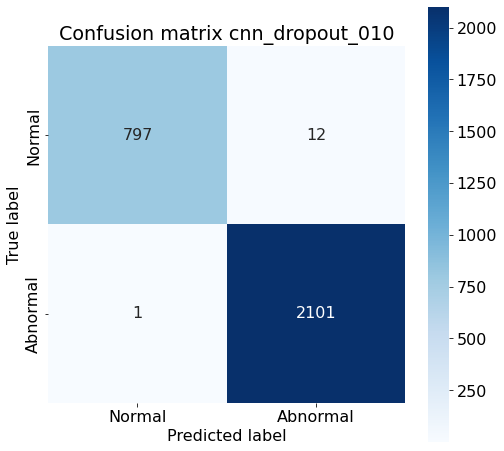

In [124]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [125]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.98516687 0.99952426]
Macro/average accuracy:  0.9923455676446824


In [126]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9987    0.9852    0.9919       809
    Abnormal     0.9943    0.9995    0.9969      2102

    accuracy                         0.9955      2911
   macro avg     0.9965    0.9923    0.9944      2911
weighted avg     0.9956    0.9955    0.9955      2911



### False Positive Rate

In [127]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  1
Percentage of sick persons that are classified as normal:  0.04757373929590866 %


# Dropout with Rate 0.08

In [128]:
name = 'cnn_dropout_008'

In [129]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
        model.add(tf.keras.layers.BatchNormalization())
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.08))
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons))
    model.add(tf.keras.layers.Activation('relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [130]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 25s 78ms/step - loss: 0.2904 - accuracy: 0.8746 - val_loss: 1.2280 - val_accuracy: 0.7218
Epoch 2/100
291/291 [==============================] - 23s 80ms/step - loss: 0.1256 - accuracy: 0.9520 - val_loss: 0.4001 - val_accuracy: 0.8536
Epoch 3/100
291/291 [==============================] - 23s 78ms/step - loss: 0.0740 - accuracy: 0.9740 - val_loss: 0.2708 - val_accuracy: 0.9158
Epoch 4/100
291/291 [==============================] - 21s 71ms/step - loss: 0.0415 - accuracy: 0.9844 - val_loss: 0.1739 - val_accuracy: 0.9425
Epoch 5/100
291/291 [==============================] - 21s 72ms/step - loss: 0.0527 - accuracy: 0.9816 - val_loss: 1.6937 - val_accuracy: 0.7827
Epoch 6/100
291/291 [==============================] - 21s 71ms/step - loss: 0.0385 - accuracy: 0.9869 - val_loss: 0.2358 - val_accuracy: 0.9412
Epoch 7/100
291/291 [==============================] - 21s 71ms/step - loss: 0.0306 - accuracy: 0.9924 - val_loss: 1.4055 - val_ac

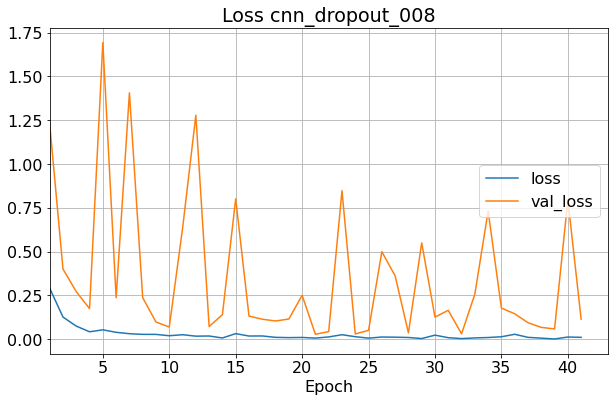

In [131]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

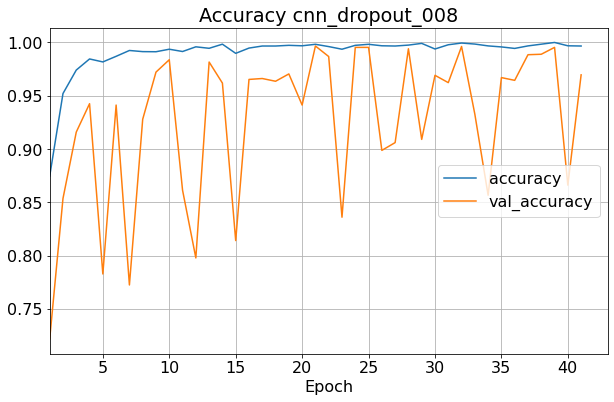

In [132]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [133]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.99382


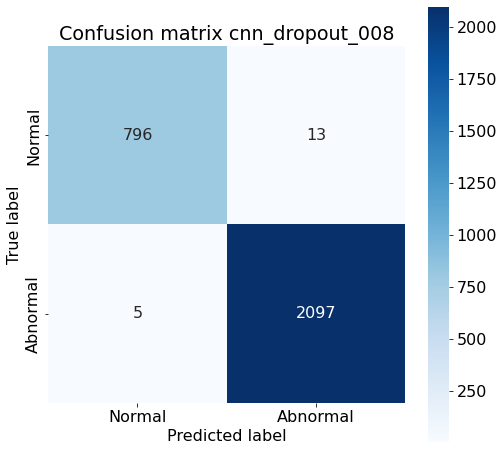

In [134]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [135]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.98393078 0.99762131]
Macro/average accuracy:  0.9907760458871944


In [136]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9938    0.9839    0.9888       809
    Abnormal     0.9938    0.9976    0.9957      2102

    accuracy                         0.9938      2911
   macro avg     0.9938    0.9908    0.9923      2911
weighted avg     0.9938    0.9938    0.9938      2911



### False Positive Rate

In [137]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  5
Percentage of sick persons that are classified as normal:  0.23786869647954328 %


# Dropout with Rate 0.12

In [138]:
name = 'cnn_dropout_012'

In [139]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
        model.add(tf.keras.layers.BatchNormalization())
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.12))
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons))
    model.add(tf.keras.layers.Activation('relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [140]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 27s 85ms/step - loss: 0.2725 - accuracy: 0.8858 - val_loss: 1.6964 - val_accuracy: 0.7205
Epoch 2/100
291/291 [==============================] - 25s 87ms/step - loss: 0.1300 - accuracy: 0.9532 - val_loss: 0.4221 - val_accuracy: 0.8467
Epoch 3/100
291/291 [==============================] - 25s 84ms/step - loss: 0.0606 - accuracy: 0.9774 - val_loss: 1.2014 - val_accuracy: 0.7742
Epoch 4/100
291/291 [==============================] - 24s 81ms/step - loss: 0.0543 - accuracy: 0.9821 - val_loss: 0.1100 - val_accuracy: 0.9639
Epoch 5/100
291/291 [==============================] - 23s 79ms/step - loss: 0.0367 - accuracy: 0.9879 - val_loss: 0.0510 - val_accuracy: 0.9833
Epoch 6/100
291/291 [==============================] - 22s 76ms/step - loss: 0.0348 - accuracy: 0.9875 - val_loss: 0.1707 - val_accuracy: 0.9438
Epoch 7/100
291/291 [==============================] - 22s 74ms/step - loss: 0.0408 - accuracy: 0.9869 - val_loss: 0.2688 - val_ac

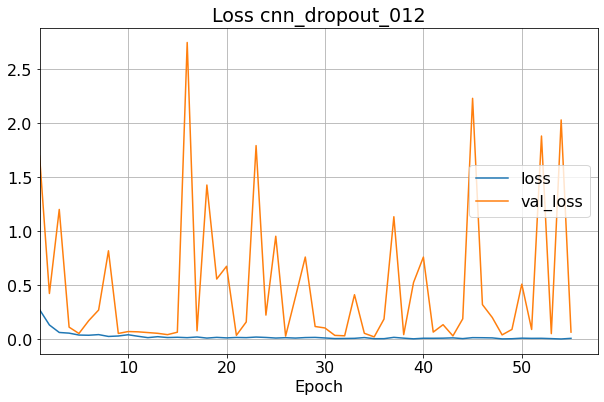

In [141]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

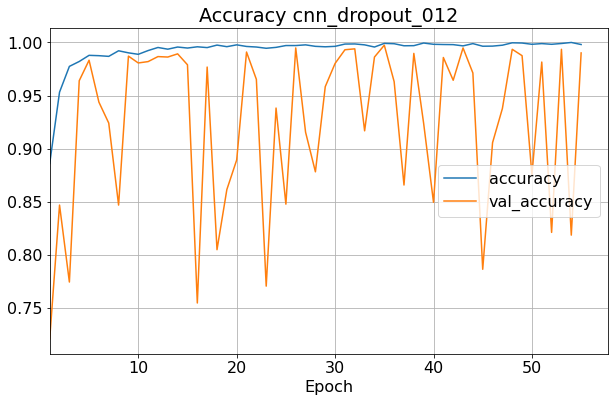

In [142]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [143]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.99347


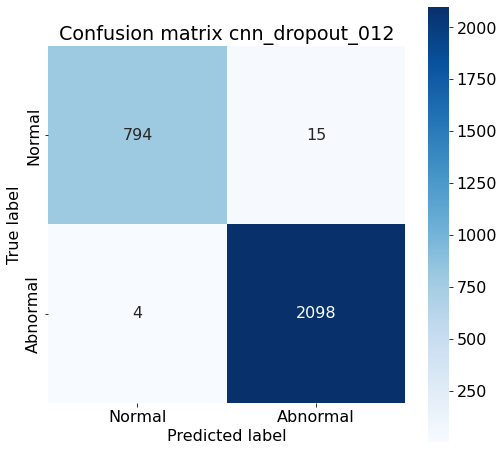

In [144]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [145]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.98145859 0.99809705]
Macro/average accuracy:  0.9897778206405342


In [146]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9950    0.9815    0.9882       809
    Abnormal     0.9929    0.9981    0.9955      2102

    accuracy                         0.9935      2911
   macro avg     0.9939    0.9898    0.9918      2911
weighted avg     0.9935    0.9935    0.9935      2911



### False Positive Rate

In [147]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  4
Percentage of sick persons that are classified as normal:  0.19029495718363465 %
